# Интеллектуальный анализ данных – весна 2024

# Домашнее задание 7: Деревья. Случайный лес



## Часть 1: Основы построения решающие дерева (1.5 балла)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import log

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [3]:
print("Энтропия: ", round(-0.8*log(0.8)-0.2*log(0.2), 2))

Энтропия:  0.5


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [4]:
print("Критерий информативности: ", round((0.8 * (1 - 0.8) + 0.2 * (1 - 0.2)) - 0.5 * 1 * (1 - 1) - 0.5 * 1 * (1 - 1), 2))

Критерий информативности:  0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [5]:
leaves = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])

print("Предикт: ", np.mean(leaves))

Предикт:  40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [6]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [7]:
##Опишу здесь идею. Для случая регрессии и численных признаков мы можем использовать
#кумулятивные суммы. Стандартную формулу дисперсии можно разложить в сумму (просто раскрыв)
#скобки у квадратов. У нас получится сумма квадртатов текущей кумулятивной суммы, удвоенное
#произведение текущего среднего и текущей кумулятивной суммы. А дальше очевидные вычисления

def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    if task == "regression":
      if feature_type == "real":
        arg_data = np.argsort(feature_vector)
        f_data = feature_vector[arg_data]

        data = target_vector[arg_data]
        ex_c = np.arange(1, len(data))
        ex_c_r = ex_c[::-1]

        cum_sum_left = np.cumsum(data)[:-1]
        cum_sum_right = np.cumsum(data[::-1])[:-1][::-1]

        mean_info_left = (cum_sum_left / ex_c)
        mean_info_right = (cum_sum_right / ex_c[::-1])

        left_ind = ((np.cumsum(data ** 2)[:-1] -
                     2 * mean_info_left * cum_sum_left +
                     ex_c * mean_info_left ** 2) / ex_c)
        right_ind = ((np.cumsum(data[::-1] ** 2)[:-1][::-1] -
                      2 * mean_info_right * cum_sum_right +
                      ex_c_r * mean_info_right ** 2) / ex_c_r)


        therefords = (f_data[1:] + f_data[:-1]) / 2
        ginis = (np.var(data) -
                  ex_c * left_ind / len(data) -
                  ex_c_r * right_ind / len(data))
        best_thereford = therefords[np.argmax(ginis)]
        gini_best = np.max(ginis)

        return (therefords, ginis, best_thereford, gini_best)


##мне сильно лень делать что то для других типов тк как делать без цикла я хз,
##а с циклом это база. Поэтому задания 2.3 и 2.4 я удалил
    pass

Эту функцию можно протестировать на датасете `California`.

In [8]:
a = (np.array([3, 2, 1, 4]))
print(np.var([1,2,3,4]))
find_best_split(np.array([1,2,3,4]), np.array([1,2,3,4]), task="regression")

1.25


(array([1.5, 2.5, 3.5]), array([0.75, 1.  , 0.75]), 2.5, 1.0)

In [9]:
from sklearn.datasets import fetch_california_housing

In [10]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [11]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

In [12]:
find_best_split(X["MedInc"].values, y, task="regression")

(array([ 0.4999,  0.4999,  0.4999, ..., 15.0001, 15.0001, 15.0001]),
 array([0.00041637, 0.00014996, 0.00047438, ..., 0.00124922, 0.00083278,
        0.00041637]),
 5.03515,
 0.4127513862016828)

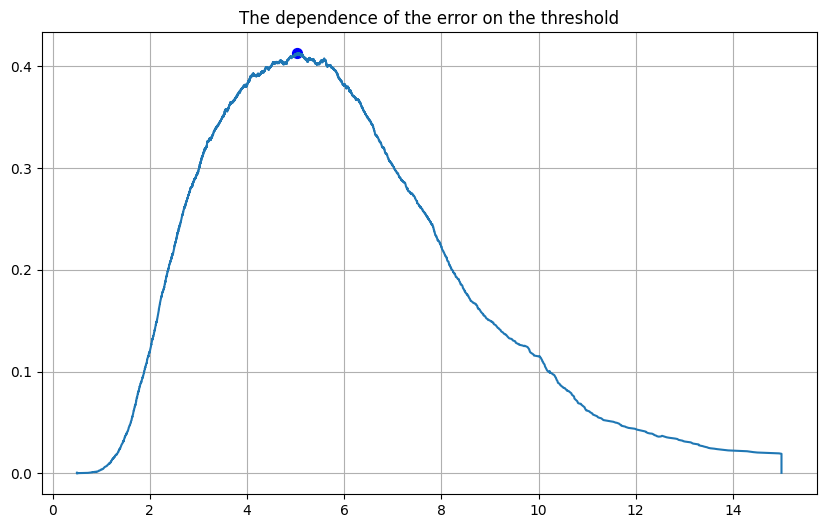

In [13]:
a, b, _, _ = find_best_split(X["MedInc"].values, y, task="regression")

plt.figure(figsize=(10, 6))
plt.plot(a, b)
plt.title("The dependence of the error on the threshold")
plt.grid()
plt.scatter(5.03515, 0.41275, color="blue", s=50)
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [14]:
find_best_split(X["Longitude"].values, y, task="regression")

(array([-124.325, -124.3  , -124.285, ..., -114.52 , -114.48 , -114.39 ]),
 array([6.10560998e-05, 1.12523656e-04, 1.82968534e-04, ...,
        2.40745710e-04, 1.72340090e-04, 9.49059097e-05]),
 -121.86,
 0.05035155930240287)

In [15]:
thereford = None
feature = None
gini_best = float('-inf')

for i in range(8):
  _, _, a_max, b_max = find_best_split(X.iloc[:, i].values, y, task="regression")
  if gini_best < b_max:
    gini_best = b_max
    thereford = a_max
    feature = i
print(" Best feature:", X.columns[feature], "\n Best gini: ", gini_best, "\n Best thereford: ", thereford)

 Best feature: MedInc 
 Best gini:  0.4127513862016828 
 Best thereford:  5.03515


**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [16]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

        # Переменная, если вы решите делать бонус
        self._feature_importances = {}


    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:

        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini
                self._feature_importances[feature_best] = self._feature_importances.get(feature_best, 0) + 1

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector < threshold
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == "terminal":
          return node["class"]
        else:
          if self._feature_types[node["feature_split"]] == "real":
              if x[node["feature_split"]] < node["threshold"]:
                  return self._predict_node(x, node["left_child"])
              else:
                  return self._predict_node(x, node["right_child"])
          elif self._feature_types[node["feature_split"]] == "categorical":
              if x[node["feature_split"]] == node["category_split"]:
                  return self._predict_node(x, node["left_child"])
              else:
                  return self._predict_node(x, node["right_child"])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [17]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [18]:
data = pd.read_csv('https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw07-trees/diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

In [46]:
data.iloc[:, :-1]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63
764,2,122,70,27,0,36.8,0.340,27
765,5,121,72,23,112,26.2,0.245,30
766,1,126,60,0,0,30.1,0.349,47


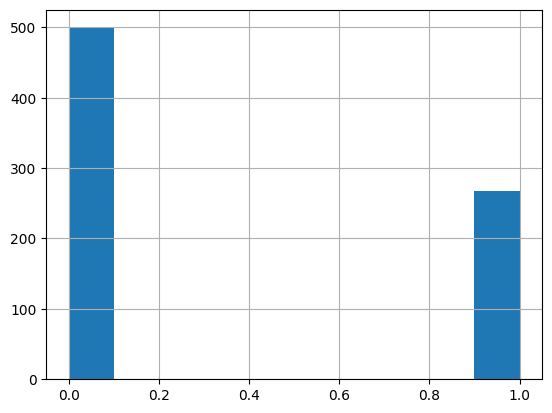

In [19]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [20]:
train, test = train_test_split(data, train_size=0.7, stratify=data["Outcome"], random_state=0)
train_train, train_val = train_test_split(train, train_size=0.7, stratify=train["Outcome"], random_state=0)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [21]:
depth = [3, 5, 10, 20, 50, 100, 500]
samples_leaf = [10, 20, 30, 40, 50]
ans = []

for i in depth:
  for j in samples_leaf:
    DTC = DecisionTreeClassifier(max_depth=i, min_samples_leaf=j)
    DTC.fit(train_train.iloc[:, :-1], train_train.iloc[:, -1])
    ans.append(f1_score(DTC.predict(train_val.iloc[:, :-1]), train_val.iloc[:, -1]))

best_depth = depth[int(np.argmax(ans) / 5)]
best_samples_leaf = samples_leaf[np.argmax(ans) % 5]

print("Best max_depth: ", best_depth)
print("Best min_samples_leaf: ", best_samples_leaf)

DTC = DecisionTreeClassifier(max_depth=best_depth, min_samples_leaf=best_samples_leaf)
DTC.fit(train.iloc[:, :-1], train.iloc[:, -1])

y_true = test.iloc[:, -1]
y_pred = DTC.predict(test.iloc[:, :-1])
print(' Accuracy: ', accuracy_score(y_true, y_pred), "\n",
      'Precision: ',precision_score(y_true, y_pred), "\n",
      'Recall: ', recall_score(y_true, y_pred), "\n",
      'AUC-ROC: ', roc_auc_score(y_true, y_pred))

Best max_depth:  5
Best min_samples_leaf:  30
 Accuracy:  0.7619047619047619 
 Precision:  0.6625 
 Recall:  0.654320987654321 
 AUC-ROC:  0.7371604938271605


In [ ]:
#Ну в целом норм#

**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [22]:
BC = BaggingClassifier(n_estimators=50)
BC.fit(train.iloc[:, :-1], train.iloc[:, -1])

y_true = test.iloc[:, -1]
y_pred = BC.predict(test.iloc[:, :-1])
print(' Accuracy: ', accuracy_score(y_true, y_pred), "\n",
      'Precision: ',precision_score(y_true, y_pred), "\n",
      'Recall: ', recall_score(y_true, y_pred), "\n",
      'AUC-ROC: ', roc_auc_score(y_true, y_pred))

 Accuracy:  0.7705627705627706 
 Precision:  0.7 
 Recall:  0.6049382716049383 
 AUC-ROC:  0.7324691358024691


In [ ]:
#Как будто лучше первый вариант, ведь в определении диабета важна полнота (т. е. найти большинство болеющих)#

**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [23]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [3, 5, 10, 20, 50, 100, 500],
    'min_samples_split' : [10, 20, 30, 40, 50]
}

RF = RandomForestClassifier(n_estimators=50)
GC = GridSearchCV(RF, params, scoring='f1')

GC.fit(train.iloc[:, :-1], train.iloc[:, -1])
print(GC.best_params_)

RF = RandomForestClassifier(n_estimators=50, max_depth=20, min_samples_split=20)
RF.fit(train.iloc[:, :-1], train.iloc[:, -1])
y_true = test.iloc[:, -1]
y_pred = RF.predict(test.iloc[:, :-1])
print(' Accuracy: ', accuracy_score(y_true, y_pred), "\n",
      'Precision: ',precision_score(y_true, y_pred), "\n",
      'Recall: ', recall_score(y_true, y_pred), "\n",
      'AUC-ROC: ', roc_auc_score(y_true, y_pred))

{'max_depth': 50, 'min_samples_split': 30}
 Accuracy:  0.8008658008658008 
 Precision:  0.7464788732394366 
 Recall:  0.654320987654321 
 AUC-ROC:  0.7671604938271605


In [ ]:
#Похожа на первую, но лучше т.к. полнота осталась той же, а остальные показатели улучшились#

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

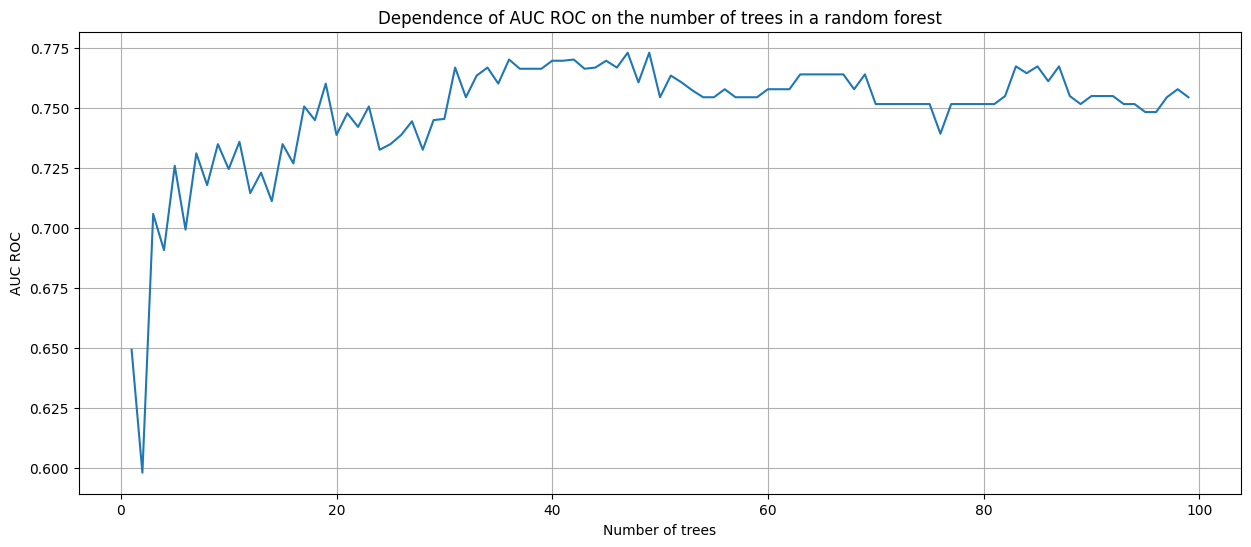

In [38]:
from sklearn import metrics

plt.figure(figsize=(15, 6))

n = [i for i in range(1, 100)]
ans = []

for i in n:
  RF = RandomForestClassifier(n_estimators=i, random_state=0)
  RF.fit(train.iloc[:, :-1], train.iloc[:, -1])
  y_true = test.iloc[:, -1]
  y_pred = RF.predict(test.iloc[:, :-1])
  ans.append(roc_auc_score(y_true, y_pred))
plt.plot(n, ans)
plt.xlabel('Number of trees')
plt.ylabel('AUC ROC')
plt.title('Dependence of AUC ROC on the number of trees in a random forest')
plt.grid()
plt.show()

In [ ]:
#Сначала увеличении количества деревьев увеличивает roc auc, но потом увеличения больше нет#

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [39]:
print(n[np.argmax(ans)])

47


In [47]:
train.iloc[:, :-1]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
34,10,122,78,31,0,27.6,0.512,45
221,2,158,90,0,0,31.6,0.805,66
531,0,107,76,0,0,45.3,0.686,24
518,13,76,60,0,0,32.8,0.180,41
650,1,91,54,25,100,25.2,0.234,23
...,...,...,...,...,...,...,...,...
628,5,128,80,0,0,34.6,0.144,45
456,1,135,54,0,0,26.7,0.687,62
398,3,82,70,0,0,21.1,0.389,25
6,3,78,50,32,88,31.0,0.248,26


In [61]:
RF = RandomForestClassifier(n_estimators=47, random_state=0)
RF.fit(train.iloc[:, :-1], train.iloc[:, -1])
importances = RF.feature_importances_
features = train.columns[:-1]
t = pd.DataFrame(importances, features, columns=["imp"])
t = t.sort_values(by="imp")
t

,imp
Insulin,0.062627
SkinThickness,0.077826
Pregnancies,0.087081
BloodPressure,0.103051
DiabetesPedigreeFunction,0.128014
BMI,0.152934
Age,0.162572
Glucose,0.225895


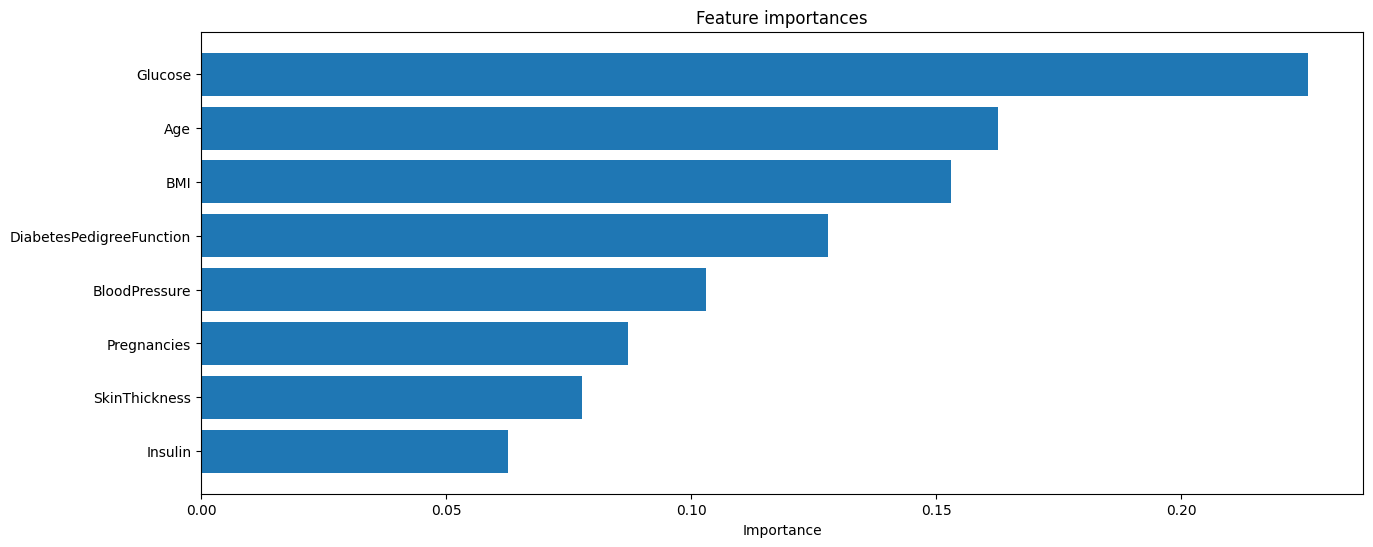

In [65]:
plt.figure(figsize=(15, 6))

plt.barh(t.index, t["imp"])
plt.xlabel('Importance')
plt.title('Feature importances')
plt.show()

In [ ]:
#Глюкоза важнейшая#